In [9]:
# Load split

import pickle

badIDs = [605515760919, 601983541597]

with open('../../Splits/RegressionAllTasks/split1.bin', 'rb') as f:
    d = pickle.load(f)
    train = []
    trainDirty = d['train']
    test = []
    testDirty = d['test']
    
    # Remove bad subjects
    for subj in trainDirty:
        if subj['ID'] not in badIDs:
            train.append(subj)
            
    for subj in testDirty:
        if subj['ID'] not in badIDs:
            test.append(subj)
    
print(len(train))
print(len(test))

466
156


In [10]:
# Load data

def loadTimeseries(_id, _dir):
    ts = None
    with open('{:s}/{:d}.bin'.format(_dir, _id), 'rb') as f:
        ts = pickle.load(f)
    return ts

train_rest_ts = [loadTimeseries(int(subj['rest']), '../../rest_fmri_power264/timeseries') for subj in train]
# train_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in train]
# train_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in train]

test_rest_ts = [loadTimeseries(int(subj['rest']), '../../rest_fmri_power264/timeseries') for subj in test]
# test_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in test]
# test_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in test]

print('Complete')

Complete


In [11]:
import numpy as np

def normalizeSubjects(subjects):
    for i in range(len(subjects)):
        subj = subjects[i]
        subj -= np.mean(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        subj /= np.std(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        if np.sum(np.isnan(subj)) > 0:
            print(i)
        if np.sum(np.isinf(subj)) > 0:
            print(i)

normalizeSubjects(train_rest_ts)
# normalizeSubjects(train_nback_ts)
# normalizeSubjects(train_emoid_ts)

normalizeSubjects(test_rest_ts)
# normalizeSubjects(test_nback_ts)
# normalizeSubjects(test_emoid_ts)

print('Complete')

Complete


In [12]:
# Create feature vectors (right now just ages, maleness, and femaless)

X_train = []
for subj in train:
    maleness = 1 if subj['meta']['Gender'] == 'M' else 0
    femaleness = 1 if maleness == 0 else 0
    feat = np.array([subj['meta']['AgeInMonths'], maleness, femaleness])
    X_train.append(feat)
    
X_test = []
for subj in test:
    maleness = 1 if subj['meta']['Gender'] == 'M' else 0
    femaleness = 1 if maleness == 0 else 0
    feat = np.array([subj['meta']['AgeInMonths'], maleness, femaleness])
    X_test.append(feat)
    
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)

print(X_train[10:20])
print('Complete')

[[193   1   0]
 [217   1   0]
 [233   1   0]
 [176   1   0]
 [116   0   1]
 [246   0   1]
 [164   1   0]
 [167   0   1]
 [202   0   1]
 [108   0   1]]
Complete


In [13]:
import torch

train_rest_ts_t = torch.from_numpy(np.stack(train_rest_ts)).float().cuda()
test_rest_ts_t = torch.from_numpy(np.stack(test_rest_ts)).float().cuda()

print('Complete')

Complete


In [23]:
import torch.nn as nn
import torch.nn.functional as F

nLat = 80
tkMul = 2

lu = nn.ReLU()
dp = nn.Dropout(p=0.1)
pdp = nn.Dropout(p=0.00)
# bn = nn.BatchNorm1d(nLat).cuda()

def makeWindows(ts, ws):
    nRoi = ts.shape[1]
    nt = ts.shape[2]
    wndws = []
    for i in range(ws):
        wndws.append(ts[:,:,i:nt-ws+i+1])
    return torch.stack(wndws, dim=3)

def xformer(seq, softmax, fc):
    nB = seq.shape[0]
    nt = seq.shape[1]
    attn = torch.einsum('bsk,btk->bstk',seq,seq)
    attn /= nLat**0.5
    attn = softmax(attn)
    seq = torch.einsum('btk,bstk->bsk',seq,attn)
    seq = seq.reshape(nB*nt,nLat)
    seq = lu(fc(seq))
    return seq.reshape(nB,nt,nLat)

def subsample(seq):
    A = seq[:,0::2,:]
    B = seq[:,1::2,:]
    if B.shape[1] < A.shape[1]:
        A = A[:,1:,:]
    return A+B/2

def applyXformerHead(seq, softmax, params):
    seq = xformer(seq, softmax, params[0]) 
    seq = subsample(seq) #60
    seq = xformer(seq, softmax, params[1])
    seq = subsample(seq) #30
    seq = xformer(seq, softmax, params[2])
    seq = subsample(seq) #15
    seq = xformer(seq, softmax, params[3])
    seq = subsample(seq) #7
    seq = xformer(seq, softmax, params[4])
    seq = subsample(seq) #3
    seq = xformer(seq, softmax, params[5])
    seq = subsample(seq) #1
#     seq = xformer(seq, softmax, params[0]) 
#     seq = subsample(seq) #115
#     seq = xformer(seq, softmax, params[1])
#     seq = subsample(seq) #57
#     seq = xformer(seq, softmax, params[2])
#     seq = subsample(seq) #28
#     seq = xformer(seq, softmax, params[3])
#     seq = subsample(seq) #14
#     seq = xformer(seq, softmax, params[4])
#     seq = subsample(seq) #7
#     seq = xformer(seq, softmax, params[5])
#     seq = subsample(seq) #3
#     seq = xformer(seq, softmax, params[6])
#     seq = subsample(seq) #1
    return seq

class Att3(nn.Module):
    def __init__(self):
        super(Att3, self).__init__()
        self.tok11 = nn.Linear(264*5,nLat*tkMul).cuda()
        self.tok12 = nn.Linear(nLat*tkMul,nLat).cuda()
        self.tok21 = nn.Linear(264*5,nLat*tkMul).cuda()
        self.tok22 = nn.Linear(nLat*tkMul,nLat).cuda()
        self.tok31 = nn.Linear(264*5,nLat*tkMul).cuda()
        self.tok32 = nn.Linear(nLat*tkMul,nLat).cuda()
        self.softmax = nn.Softmax(dim=2)
        self.h1 = nn.ModuleList([nn.Linear(nLat,nLat).cuda() for i in range(6)])
        self.h2 = nn.ModuleList([nn.Linear(nLat,nLat).cuda() for i in range(6)])
        self.h3 = nn.ModuleList([nn.Linear(nLat,nLat).cuda() for i in range(6)])
        self.final = nn.Linear(nLat*3,1).cuda()
        
    def forward(self, x):
        nB = x.shape[0]
        nt = x.shape[2]
        
        # Pearsons
#         ps = []
#         for i in range(nB):
#             ps.append((x[i]@x[i].T/124).flatten())
#         ps = pdp(torch.stack(ps))
        
        xw = makeWindows(x, 5)
        xw = xw.permute(0,2,1,3)
        xw = xw.reshape(nB*(nt-4),-1)
        
        tok1 = lu(self.tok12(dp(lu(self.tok11(xw)))))
        seq1 = tok1.reshape(nB,nt-4,nLat)
        
        tok2 = lu(self.tok22(dp(lu(self.tok21(xw)))))
        seq2 = tok1.reshape(nB,nt-4,nLat)
        
        tok3 = lu(self.tok32(dp(lu(self.tok31(xw)))))
        seq3 = tok1.reshape(nB,nt-4,nLat)
        
        seq1 = applyXformerHead(seq1, self.softmax, self.h1)
        seq2 = applyXformerHead(seq2, self.softmax, self.h2)
        seq3 = applyXformerHead(seq3, self.softmax, self.h3)
        
        seq1 = seq1.reshape(nB,nLat)
        seq2 = seq2.reshape(nB,nLat)
        seq3 = seq3.reshape(nB,nLat)
        
        seq = torch.cat([seq1, seq2, seq3], dim=1)
        
        return self.final(seq)

att3 = Att3()
optim = torch.optim.Adam(att3.parameters(), lr=5e-4)
print('Complete')

Complete


In [24]:
import random

running = 0
nEpoch = 2000
pPeriod = 50
nB = 10
N = train_rest_ts_t.shape[0]

for epoch in range(nEpoch):
    batch = []
    truth = torch.zeros(nB).float().cuda()
    for i in range(nB):
        idx = random.randint(0,N-1)
        batch.append(train_rest_ts_t[idx])
        truth[i] = X_train[idx, 0]
    batch = torch.stack(batch)
    optim.zero_grad()
    pred = att3(batch).flatten()
    loss = torch.sum((pred-truth)**2)
    loss.backward()
    running += loss.detach().cpu()
    optim.step()
    if epoch % pPeriod == 0 or epoch == nEpoch-1:
        if epoch != 0:
            if epoch % pPeriod != 0:
                running /= epoch % pPeriod
            else:
                running /= pPeriod
        print('epoch {:d} loss={:f}'.format(epoch, ((running/nB)**0.5)/12))
        running = 0

print('Finished training')

epoch 0 loss=15.168349
epoch 50 loss=11.567300
epoch 100 loss=5.953133
epoch 150 loss=5.189517
epoch 200 loss=5.256531
epoch 250 loss=4.533243
epoch 300 loss=4.023021
epoch 350 loss=3.580334
epoch 400 loss=3.206743
epoch 450 loss=3.131046
epoch 500 loss=2.767898
epoch 550 loss=2.555918
epoch 600 loss=2.234826
epoch 650 loss=2.031570
epoch 700 loss=1.842969
epoch 750 loss=1.835788
epoch 800 loss=1.484617
epoch 850 loss=1.421068
epoch 900 loss=1.185485
epoch 950 loss=1.106591
epoch 1000 loss=1.072303
epoch 1050 loss=0.945624
epoch 1100 loss=0.912319
epoch 1150 loss=0.879418
epoch 1200 loss=0.775011
epoch 1250 loss=0.819442
epoch 1300 loss=0.710860
epoch 1350 loss=0.679197
epoch 1400 loss=0.744246
epoch 1450 loss=0.645492
epoch 1500 loss=0.748089
epoch 1550 loss=1.018499
epoch 1600 loss=0.761564
epoch 1650 loss=0.740352
epoch 1700 loss=0.697428
epoch 1750 loss=0.625440
epoch 1800 loss=0.689469
epoch 1850 loss=0.728866
epoch 1900 loss=0.706605
epoch 1950 loss=0.683422
epoch 1999 loss=0.601

[[1.         0.29009035]
 [0.29009035 1.        ]]
3.351468018704716
2.7472236502883782


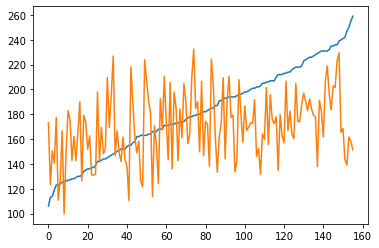

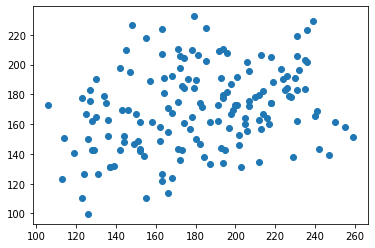

In [25]:
import matplotlib.pyplot as plt

preds = []
for i in range(int(test_rest_ts_t.shape[0]/10+1)*10):
    i0 = i*10
    i1 = (i+1)*10
    if i0 >= test_rest_ts_t.shape[0]:
        break
    if i1 > test_rest_ts_t.shape[0]:
        i1 = test_rest_ts_t.shape[0]
    preds.append(att3(test_rest_ts_t[i0:i1,:,:]).detach().cpu().numpy().flatten())
predY = np.concatenate(preds)

idcs = np.argsort(X_test[:,0])
yPred = predY[idcs]
y = X_test[:,0][idcs]

corr = np.corrcoef(y, yPred)
rmse = (np.sum((y-yPred)**2)/len(y))**0.5/12
mae = np.sum(np.abs(y-yPred))/12/len(y)

print(corr)
print(rmse)
print(mae)

plt.plot(y, label='Truth')
plt.plot(yPred, label='Prediction')
plt.show()

plt.scatter(y, yPred)
plt.show()

In [22]:
import torch

print(torch.cuda.get_device_name(0))
print('Memory Usage:')
print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Quadro K2200
Memory Usage:
Allocated: 0.2 GB
Cached:    0.9 GB


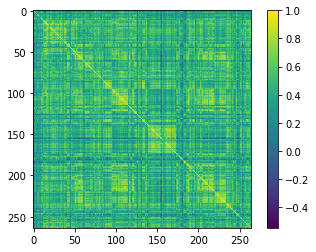

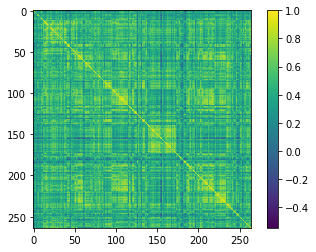

In [67]:
sub = train_rest_ts_t[0].cpu().numpy()
p = sub@sub.T/124

plt.imshow(p)
plt.colorbar()
plt.show()

p_valid = np.corrcoef(sub)

plt.imshow(p_valid)
plt.colorbar()
plt.show()

In [106]:
print(train_rest_ts_t.shape)

torch.Size([466, 264, 231])
